In [1]:
import matplotlib.pyplot as plt

import numpy as np
import torch

from models import ResNetCifar
from datas import get_dataset_cifar10

# Data Set

In [2]:
trainset, trainloader, testset, testloader, classes = get_dataset_cifar10(32)
print(f'training with number of samples {len(trainset)}, number of train dataloader {len(trainloader)}') 
print(f'testing with number of samples {len(testset)}, number of train dataloader {len(testloader)}') 

Files already downloaded and verified
Files already downloaded and verified
training with number of samples 50000, number of train dataloader 1563
testing with number of samples 10000, number of train dataloader 313


# Experiment

In [3]:
def get_model_dtype(model):
    return next(model.parameters()).dtype

def train(model, optim):
    num_epoch = 20
    model = model.to('cuda')
    dtype = get_model_dtype(model)
    epoch_eval_losses = []
    epoch_train_avg_loss = []
    epoch_eval_accs = []
    batch_train_losses = []
    losser = torch.nn.CrossEntropyLoss()
    for epoch in range(num_epoch):
        epoch_train_losses = []
        for batch in trainloader:
            samples, labels = batch
            samples = samples.to('cuda', dtype=dtype)
            labels = labels.to('cuda', dtype=torch.long)
            pred = model(samples)
            loss = losser(pred, labels)
            optim.zero_grad()
            loss.backward()
            optim.step()
            epoch_train_losses.append(loss.item())

        num_samples, correct, eval_loss = 0, 0, 0
        for batch in testloader:
            with torch.no_grad():
                samples, labels = batch
                samples = samples.to('cuda', dtype=dtype)
                labels = labels.to('cuda', dtype=torch.long)
                model_output = model(samples)
                pred = torch.argmax(model_output, dim=-1)
                num_correct = torch.sum(pred == labels)
                num_samples += pred.shape[0]
                correct += num_correct
                eval_loss += torch.nn.functional.cross_entropy(model_output, labels, reduction='none').sum()
        
        epoch_train_losses = np.array(epoch_train_losses).mean()
        epch_eval_loss = eval_loss/num_samples
        epoch_eval_acc = correct / num_samples
        epoch_train_avg_loss.append(epoch_train_losses.item())
        epoch_eval_losses.append(epch_eval_loss.item())
        batch_train_losses.extend(epoch_train_avg_loss)
        epoch_eval_accs.append(epoch_eval_acc)
        print(f'epoch {epoch}, train avg loss {epoch_train_losses}, eval loss {epch_eval_loss: .02f}, eval acc {epoch_eval_acc: .02f}')
    return epoch_train_avg_loss, batch_train_losses, epoch_eval_losses, epoch_eval_accs

## Train With Adam

In [4]:
model = ResNetCifar(n=3)
optim = torch.optim.Adam(model.parameters())
epoch_train_avg_loss, batch_train_losses, epoch_eval_losses, epoch_eval_accs = train(model, optim)

epoch 0, train avg loss 1.2823205189070332, eval loss  0.98, eval acc  0.65


# Plotting the results

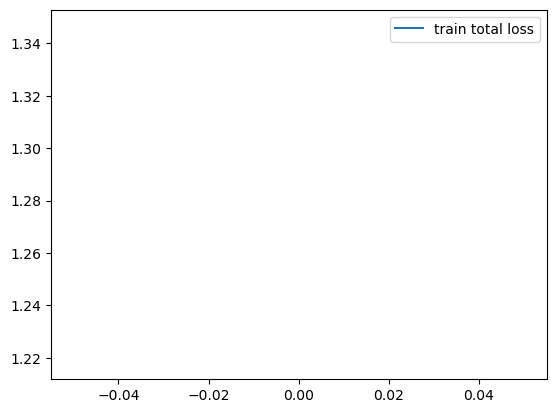

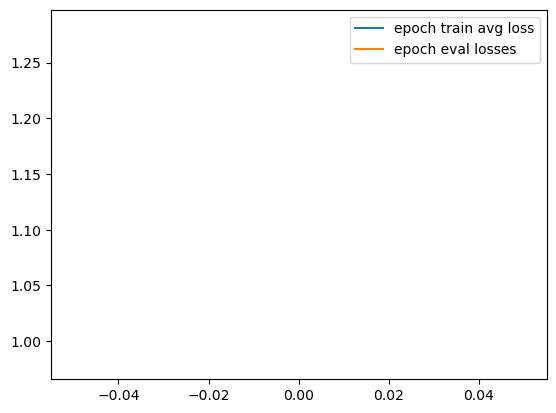

In [6]:

plt.plot(range(len(batch_train_losses)), batch_train_losses, label='train total loss')
plt.legend()
plt.show()

plt.plot(range(len(batch_train_losses)), epoch_train_avg_loss, label='epoch train avg loss')
plt.plot(range(len(batch_train_losses)), epoch_eval_losses, label='epoch eval losses')
plt.legend()
